<a href="https://colab.research.google.com/github/jiaxianggao/2d-watertank-supervised/blob/main/MLP_for_water_tank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install setuptools==65.5.0 "wheel<0.40.0"

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l

In [ ]:
!pip install matplotlib_inline==0.1.1

In [ ]:
import torch
import numpy as np
import scipy.io as sio
from torch import nn
from torch.utils import data
from d2l import torch as d2l

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the .mat file
mat_train = sio.loadmat('/content/drive/Shareddrives/PhD - Jiaxiang/Codes/2D Watertank/Simple examples/case1_1_skip3_fn_train.mat')
mat_test = sio.loadmat('/content/drive/Shareddrives/PhD - Jiaxiang/Codes/2D Watertank/Simple examples/case1_1_skip3_fn_test.mat')
mat_pred = sio.loadmat('/content/drive/Shareddrives/PhD - Jiaxiang/Codes/2D Watertank/Simple examples/case1_1_skip3_fn_pred.mat')

In [ ]:
# Read data
features_train = torch.from_numpy(np.transpose(mat_train['Xtrain'])).float()
labels_train = torch.from_numpy(np.transpose(mat_train['Ytrain'])).float()
features_test = torch.from_numpy(np.transpose(mat_test['XValidation'])).float()
labels_test = torch.from_numpy(np.transpose(mat_test['YValidation'])).float()

In [ ]:
# Load data
batch_size = 128
def load_array(data_arrays, batch_size, is_train=True, num_workers=2):
  dataset = data.TensorDataset(*data_arrays)
  return data.DataLoader(dataset, batch_size, shuffle=is_train, num_workers=num_workers)

train_iter = load_array((features_train, labels_train), batch_size)
test_iter = load_array((features_test, labels_test), batch_size, is_train=False)

In [ ]:
# Network achitechure
net = nn.Sequential(nn.Linear(256, 1000),
                    nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(1000,2000),
                    nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(2000,3000),
                    nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(3000, 2959)
                    )
 #initialize parameters
# def init_weights(m):
#     if type(m) == nn.Linear or type(m) == nn.Conv2d:
#         nn.init.xavier_uniform_(m.weight)
# net.apply(init_weights)

In [ ]:
# load pre trained model
net_save_name = '2Dwatertank.pth'
path = F"/content/drive/Shareddrives/PhD - Jiaxiang/Codes/2D Watertank/Simple examples/{net_save_name}"
net.load_state_dict(torch.load(path))

In [ ]:
def evaluate_loss_gpu(net, data_iter, loss, device=None):
    """compute loss on dataset using GPU"""
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    # total loss，total number of samples
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            l = loss(net(X), y)
            metric.add(l.sum(), X.shape[0])
    return metric[0] / metric[1]

In [ ]:
def l2_penalty():
  'Replace pow(2) with abs() for L1 regularization, not recommended'
  return sum(p.pow(2).sum() for p in net.parameters())

In [ ]:
# Training
def train_regression(net, train_iter, test_iter, num_epochs, lr, lambd, device):
    """Using GPU to train a regression model"""
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = d2l.squared_loss
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        # total loss，total number of samples
        net.train()
        for X, y in train_iter:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y).sum(axis=1).mean() + lambd * l2_penalty()
            l.backward()
            optimizer.step()
        if epoch == 0 or (epoch + 1) % 10 == 0:
          train_l = evaluate_loss_gpu(net, train_iter, loss)
          test_l  = evaluate_loss_gpu(net, test_iter, loss)
          print(f'train loss {train_l:.3f}, '
                f'test loss {test_l:.3f}')
          animator.add(epoch + 1, (train_l, test_l))

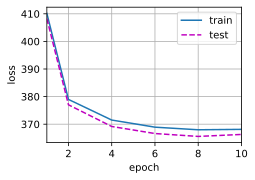

In [ ]:
lr, num_epochs, lambd = 0.00005, 1000, 0.001
train_regression(net, train_iter, test_iter, num_epochs, lr, lambd, d2l.try_gpu())

In [ ]:
# Save the model
net_save_name = '2Dwatertank.pth'
path = F"/content/drive/Shareddrives/PhD - Jiaxiang/Codes/2D Watertank/Simple examples/{net_save_name}"
torch.save(net.state_dict(), path)

In [ ]:
# Use the model to make predictions
input = torch.from_numpy(np.transpose(mat_pred['Uel'])).float()
net = net.to("cpu")
output = net(input).detach().t().numpy()
sio.savemat(''/content/drive/MyDrive/Colab Notebooks/2D Water tank/pred_watertank.mat', {'sigma_pred':output})